# Predicting Career Satisfaction From Stack Overflow Data

### Luis Gomez | Sam Rondinelli | Zachary Rudebeck


# Intro

Not all technologies are created equal, and it’s obvious that some are much more enjoyable to work with than others. With our project, we have utilized community data on six specific variables and thirty-four total possible options to determine if a correlation exists between developer job satisfaction/happiness and these six variables. Then, after finding if this correlation exists, we decided to take it one step further by seeing if we could fit an algorithm to predict developer happiness.


# Data

To determine this correlation, we used the 2018 Stack Overflow Developer Survey. Stack Overflow is one of the most widely used developer resources on the internet, with over 10.4 million registered and unregistered users. Every year they conduct a community-wide survey of over 90,000 developers, the largest and most comprehensive developer survey in the world. This survey collects data on many aspects of programming both professionally and as an amateur, with many data points that were relevant to our stated goal. Among a dataset of almost 120 columns, we specifically looked at framework worked with, operating system, number of monitors, whether or not the developer has a Stack Overflow Account, how many hours developers spend on their computer in a day, and how many hours they spend outside in a day.


## Cleaning 2018 Stack Overflow Developer Survey Data

### Read the dataset


In [3]:
import pandas as pd
dataset = pd.read_csv('../survey_results_public.csv')


### Choose a subset of variables from the dataset for training data


In [4]:
X_subset = dataset[[
               'CareerSatisfaction',
               'FrameworkWorkedWith',
               'OperatingSystem',
               'NumberMonitors',
               'StackOverflowHasAccount',
               'HoursComputer',
               'HoursOutside'
]]

print('shape before dropna: ', X_subset.shape)
# drop any rows with null data
X_subset = X_subset.dropna()
print('shape after dropna: ', X_subset.shape)


shape before dropna:  (98855, 7)
shape after dropna:  (43962, 7)


### Separate CareerSatisfaction (what we want to predict) from the rest of the columns


In [5]:
# load the career satisfaction column into y
y = X_subset['CareerSatisfaction']
X_subset = X_subset.drop('CareerSatisfaction', axis=1)


### Create dummies / one-hot encode y
Each person could choose 1 of 7 ways to rate their career satisfaction.

To simplify the data for ML algorithms, we will split this single column into 7 different columns, one for each category of response.


In [44]:
print(y.shape)
y = pd.get_dummies(y)
# notice the shape after creating dummies is (43962, 7), because get_dummies() created a new column for each category of answer in the survey
print(y.shape)


print('Also, check out the different options for Career Satisfaction:')
print(y.columns.values)

(43962, 7)
(43962, 7)
Also, check out the different options for Career Satisfaction
['Extremely dissatisfied' 'Extremely satisfied' 'Moderately dissatisfied'
 'Moderately satisfied' 'Neither satisfied nor dissatisfied'
 'Slightly dissatisfied' 'Slightly satisfied']


### For the `FrameworkWorkedWith` column, one-hot encode each answer

The responses in the `FrameworkWorkedWith` column correspond to a semicolon separated list (e.g `.NET Core;Spark`).
The goal of this section of the code is twofold:
1. find all the Frameworks which respondents were able to choose from
2. turn each string response into a one-hot encoded vector (e.g. `.NET Core;Spark` becomes `[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]`)



In [7]:
def one_hot_encode(categories, data):
    '''
    takes in a list of categories and a list of data and returns a one-hot encoded vector 
    :param categories: 
    :param data: 
    :return: 
    '''
    one_hot_vector = [0 for _ in range(len(categories))] # initialize a vector with 0s for each category
    for item in data:
        for i, category in enumerate(categories):
            if item == category:
                one_hot_vector[i] = 1
    return one_hot_vector


In [8]:
# start by getting every possible category of response
set_of_responses = set()
for resp in X_subset['FrameworkWorkedWith']:
    # parse the response into a list of values
    resp_list = resp.split(';')
    # add to the set of total responses
    resp_set = set(resp_list)
    set_of_responses.update(resp_set)
# put the frameworks in alphabetical order for prettiness
sorted_set_of_responses = sorted(set_of_responses)


Now that we've parsed all the responses from semi-colon separated strings into arrays and found all the categories of responses for the FrameworkWorkedWith column, we can one-hot encode it easily.


In [9]:
# iterate thru responses once more to map the list of responses into one-hot encoded columns
data = {}
for i, resp in X_subset['FrameworkWorkedWith'].iteritems():
    resp_list = resp.split(';')
    one_hot_vector = one_hot_encode(list(sorted_set_of_responses) , resp_list)
    data[i] = one_hot_vector

# build a new dataframe that will replace the FrameworkWorkedWith column with the dict we just built
framework_col_replacement = pd.DataFrame().from_dict(data, orient='index', columns=list(sorted_set_of_responses))
print(framework_col_replacement.head())


   .NET Core  Angular  Cordova  Django  Hadoop  Node.js  React  Spark  Spring  \
0          0        0        0       1       0        0      1      0       0   
1          0        0        0       1       0        0      0      0       0   
5          0        1        0       0       0        1      0      0       0   
6          0        0        0       0       0        1      1      0       0   
7          0        1        0       0       0        1      0      0       0   

   TensorFlow  Torch/PyTorch  Xamarin  
0           0              0        0  
1           0              0        0  
5           0              0        0  
6           0              0        0  
7           0              0        0  


### Now replace the FrameworkWorkedWith column with the new one hot encoded df we just built


In [13]:
X_subset_no_framework_col = X_subset.drop('FrameworkWorkedWith', axis=1)
X_subset_with_one_hot_df = pd.concat([X_subset_no_framework_col, framework_col_replacement], axis=1)

### Create dummies for the rest of the categorical variables


In [14]:
X_cleaned = pd.get_dummies(X_subset_with_one_hot_df)
print('The final, cleaned features we will train on:')
print(X_cleaned.columns.values)

The final, cleaned features we will train on:
['.NET Core' 'Angular' 'Cordova' 'Django' 'Hadoop' 'Node.js' 'React'
 'Spark' 'Spring' 'TensorFlow' 'Torch/PyTorch' 'Xamarin'
 'OperatingSystem_BSD/Unix' 'OperatingSystem_Linux-based'
 'OperatingSystem_MacOS' 'OperatingSystem_Windows' 'NumberMonitors_1'
 'NumberMonitors_2' 'NumberMonitors_3' 'NumberMonitors_4'
 'NumberMonitors_More than 4'
 "StackOverflowHasAccount_I'm not sure / I can't remember"
 'StackOverflowHasAccount_No' 'StackOverflowHasAccount_Yes'
 'HoursComputer_1 - 4 hours' 'HoursComputer_5 - 8 hours'
 'HoursComputer_9 - 12 hours' 'HoursComputer_Less than 1 hour'
 'HoursComputer_Over 12 hours' 'HoursOutside_1 - 2 hours'
 'HoursOutside_3 - 4 hours' 'HoursOutside_30 - 59 minutes'
 'HoursOutside_Less than 30 minutes' 'HoursOutside_Over 4 hours']


### Export new CSV file with cleaned data

In [15]:
clean_dataset = y.join(X_cleaned)
clean_dataset.to_csv('../clean_dataset.csv', index=False)



## Determining Feature Importance

### Import relevant packages and read in the dataset

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier

# Read in the data
df = pd.read_csv('../clean_dataset.csv')

y = df.iloc[:,0:7]
X = df.iloc[:,7:]

### Fit a forest and determine feature importances

In [28]:
# Build and fit a random forest classifier
forest = ExtraTreesClassifier(n_estimators=100, random_state=12)
forest.fit(X, y)

# Get feature importances from the tree classifier
importances = forest.feature_importances_

# Determine error bars for importances
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

### Print out results

Feature ranking:
Feature 5: Node.js (0.082524)
Feature 1: Angular (0.075929)
Feature 0: .NET Core (0.070871)
Feature 3: Django (0.070357)
Feature 6: React (0.063486)
Feature 8: Spring (0.062008)
Feature 2: Cordova (0.055843)
Feature 9: TensorFlow (0.047023)
Feature 11: Xamarin (0.045898)
Feature 4: Hadoop (0.040268)
Feature 7: Spark (0.035251)
Feature 29: HoursOutside_1 - 2 hours (0.029365)
Feature 23: StackOverflowHasAccount_Yes (0.025637)
Feature 32: HoursOutside_Less than 30 minutes (0.025252)
Feature 25: HoursComputer_5 - 8 hours (0.025065)
Feature 26: HoursComputer_9 - 12 hours (0.024727)
Feature 31: HoursOutside_30 - 59 minutes (0.024266)
Feature 22: StackOverflowHasAccount_No (0.022403)
Feature 30: HoursOutside_3 - 4 hours (0.020820)
Feature 10: Torch/PyTorch (0.017658)
Feature 21: StackOverflowHasAccount_I'm not sure / I can't remember (0.016986)
Feature 28: HoursComputer_Over 12 hours (0.015461)
Feature 13: OperatingSystem_Linux-based (0.015308)
Feature 15: OperatingSystem_Win

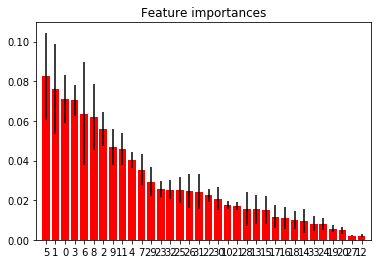

In [29]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("Feature %d: %s (%f)" % (indices[f], X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Looking at the above results, it's easy to see that even the most heavily weighted feature barely affects the outcome, which would indicate very little correlation between any of the variables and the Y value.



## Fitting a neural net

### Read the cleaned dataset

In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
df = pd.read_csv('../clean_dataset.csv')

### Define x and y

In [17]:
y = df.iloc[:,0:7]
x = df.iloc[:,7:]
x.head(10)

.NET Core  Angular  Cordova  Django  Hadoop  Node.js  React  Spark  Spring  \
0          0        0        0       1       0        0      1      0       0   
1          0        0        0       1       0        0      0      0       0   
2          0        1        0       0       0        1      0      0       0   
3          0        0        0       0       0        1      1      0       0   
4          0        1        0       0       0        1      0      0       0   
5          0        0        0       0       1        1      1      1       0   
6          0        0        0       0       0        0      0      0       1   
7          1        0        0       0       0        0      0      0       0   
8          0        1        0       0       0        0      0      0       0   
9          0        1        0       0       0        1      0      0       0   

   TensorFlow  ...  HoursComputer_1 - 4 hours  HoursComputer_5 - 8 hours  \
0           0  ...                          0                          0   
1           0  ...                          0                          1   
2           0  ...                          0                          0   
3           0  ...                          0                          0   
4           0  ...                          0                          0   
5           0  ...                          0                          0   
6           0  ...                          0                          1   
7           0  ...                          0                          0   
8           0  ...                          0                          0   
9           0  ...                          0                          0   

   HoursComputer_9 - 12 hours  HoursComputer_Less than 1 hour  \
0                           1                               0   
1                           0                               0   
2                           1                               0   
3                           0                               0   
4                           0                               0   
5                           1                               0   
6                           0                               0   
7                           1                               0   
8                           1                               0   
9                           1                               0   

   HoursComputer_Over 12 hours  HoursOutside_1 - 2 hours  \
0                            0                         1   
1                            0                         0   
2                            0                         0   
3                            1                         0   
4                            1                         1   
5                            0                         0   
6                            0                         1   
7                            0                         0   
8                            0                         1   
9                            0                         0   

   HoursOutside_3 - 4 hours  HoursOutside_30 - 59 minutes  \
0                         0                             0   
1                         0                             1   
2                         0                             1   
3                         0                             0   
4                         0                             0   
5                         0                             0   
6                         0                             0   
7                         0                             1   
8                         0                             0   
9                         0                             1   

   HoursOutside_Less than 30 minutes  HoursOutside_Over 4 hours  
0                                  0                          0  
1                                  0                          0  
2                          

### Split testing and training data

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

### Build neural net

In [19]:
nn=MLPRegressor(activation='logistic', solver='sgd',hidden_layer_sizes=(1),random_state=1)

In [20]:
nn.fit(x_train,y_train)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=1, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

### Test neural net

In [42]:
prediction = nn.predict(x_test)
for i in range(10):
    print('actual:\n', y_test.iloc[i])
    print('prediction:\n', y_test.columns[np.argmax(prediction[i])])
    print()
print('Yay, we are doing worse than random guess!')

actual:
 Extremely dissatisfied                0
Extremely satisfied                   0
Moderately dissatisfied               0
Moderately satisfied                  1
Neither satisfied nor dissatisfied    0
Slightly dissatisfied                 0
Slightly satisfied                    0
Name: 19448, dtype: int64
prediction:  Moderately satisfied
actual:
 Extremely dissatisfied                0
Extremely satisfied                   0
Moderately dissatisfied               0
Moderately satisfied                  0
Neither satisfied nor dissatisfied    0
Slightly dissatisfied                 0
Slightly satisfied                    1
Name: 4506, dtype: int64
prediction:  Moderately satisfied
actual:
 Extremely dissatisfied                0
Extremely satisfied                   0
Moderately dissatisfied               0
Moderately satisfied                  1
Neither satisfied nor dissatisfied    0
Slightly dissatisfied                 0
Slightly satisfied                    0
Name: 3133, dt

In [26]:
print(nn.score(x_test, y_test))
print('Wow, pretty bad!')


-0.002357277583699144
Wow, pretty bad!


## Fitting a Tree

In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display, Image

In [31]:
df = pd.read_csv('../clean_dataset.csv')

In [35]:
y = df.iloc[:,0:7]
x = df.iloc[:,7:]
x.head()

.NET Core  Angular  Cordova  Django  Hadoop  Node.js  React  Spark  Spring  \
0          0        0        0       1       0        0      1      0       0   
1          0        0        0       1       0        0      0      0       0   
2          0        1        0       0       0        1      0      0       0   
3          0        0        0       0       0        1      1      0       0   
4          0        1        0       0       0        1      0      0       0   

   TensorFlow  ...  HoursComputer_1 - 4 hours  HoursComputer_5 - 8 hours  \
0           0  ...                          0                          0   
1           0  ...                          0                          1   
2           0  ...                          0                          0   
3           0  ...                          0                          0   
4           0  ...                          0                          0   

   HoursComputer_9 - 12 hours  HoursComputer_Less than 1 hour  \
0                           1                               0   
1                           0                               0   
2                           1                               0   
3                           0                               0   
4                           0                               0   

   HoursComputer_Over 12 hours  HoursOutside_1 - 2 hours  \
0                            0                         1   
1                            0                         0   
2                            0                         0   
3                            1                         0   
4                            1                         1   

   HoursOutside_3 - 4 hours  HoursOutside_30 - 59 minutes  \
0                         0                             0   
1                         0                             1   
2                         0                             1   
3                         0                             0   
4                         0                             0   

   HoursOutside_Less than 30 minutes  HoursOutside_Over 4 hours  
0                                  0                          0  
1                                  0                          0  
2                                  0                          0  
3                                  1                          0  
4                                  0                          0  

[5 rows x 34 columns]

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)
clf = DecisionTreeClassifier(random_state=12)
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=12,
            splitter='best')

## Test accuracy

In [37]:
clf.score(x_test, y_test)

0.09666780393494825

### We can also visualize the tree

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0631495 to fit



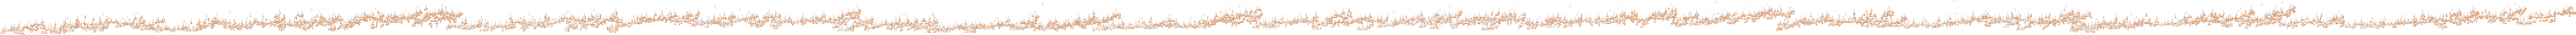

In [39]:
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(clf,
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())


## Linear Regression 

### Read the cleaned dataset

In [38]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt
from pandas import Series, DataFrame

df = pd.read_csv('../clean_dataset.csv')

### Define x and y

In [39]:
y = df.iloc[:,0:7]
x = df.iloc[:,7:]
x.head()

.NET Core  Angular  Cordova  Django  Hadoop  Node.js  React  Spark  Spring  \
0          0        0        0       1       0        0      1      0       0   
1          0        0        0       1       0        0      0      0       0   
2          0        1        0       0       0        1      0      0       0   
3          0        0        0       0       0        1      1      0       0   
4          0        1        0       0       0        1      0      0       0   

   TensorFlow  ...  HoursComputer_1 - 4 hours  HoursComputer_5 - 8 hours  \
0           0  ...                          0                          0   
1           0  ...                          0                          1   
2           0  ...                          0                          0   
3           0  ...                          0                          0   
4           0  ...                          0                          0   

   HoursComputer_9 - 12 hours  HoursComputer_Less than 1 hour  \
0                           1                               0   
1                           0                               0   
2                           1                               0   
3                           0                               0   
4                           0                               0   

   HoursComputer_Over 12 hours  HoursOutside_1 - 2 hours  \
0                            0                         1   
1                            0                         0   
2                            0                         0   
3                            1                         0   
4                            1                         1   

   HoursOutside_3 - 4 hours  HoursOutside_30 - 59 minutes  \
0                         0                             0   
1                         0                             1   
2                         0                             1   
3                         0                             0   
4                         0                             0   

   HoursOutside_Less than 30 minutes  HoursOutside_Over 4 hours  
0                                  0                          0  
1                                  0                          0  
2                                  0                          0  
3                                  1                          0  
4                                  0                          0  

[5 rows x 34 columns]

### Run Linear Regression

In [40]:
reg = LinearRegression().fit(x, y)

In [41]:
reg.score(x, y)

0.006233034016780044

# Conclusion

After running various algorithms, it was concluded that little, if any, correlation exists between the 6 variables tested with 34 total possible options. If this research were to be continued, additional variables would be tested along with additional algorithms. More data points would also be tested from 2018 as well as previous years. This would allow us to not only test for correlations to developer happiness, but also see the way in which these correlations change over time. We were disappointed not to find a correlation between any of these variables and developer happiness, but perhaps